In [289]:
import numpy as np
from PIL import Image
import os
import time
import seaborn as sns
import math
import matplotlib.pyplot as plt

## Pre-procesamiento de imágenes

Función para convertir imágenes a vectores normalizados en escala de grises:

In [387]:
def image_convert(dir, new_size):

    imagenes = []

    for filename in os.listdir(dir):

        file_path = os.path.join(dir, filename)
        
        if os.path.isfile(file_path):
            
            if not filename.lower().endswith('.png'):
                continue
            try:
                with Image.open(file_path) as img:
                    img = img.resize(new_size) 
                    img = img.convert('L')
                    img_array = np.array(img)/255.0
                    img_vector = img_array.reshape((new_size[0]**2)) 
                    imagenes.append(img_vector)
            except Exception as e:
                print(f"Error {file_path}: {e}")

    return np.array(imagenes)


Configuramos los tamaños y elegimos aquel que se utilizará para los experimentos:

In [388]:
original = (256, 256)
mediano =  (128, 128)
chico = (64, 64)
muy_chico = (32, 32)

size = mediano

In [389]:
# Healthy
src_dir = 'DatasetTP/Healthy'
i_healthy = image_convert(src_dir, size) # Imágenes de pacientes sanos
d_healthy = np.ones((i_healthy.shape[0], 1)) * 0 # Vector de diagnósticos para la gente sana (0)

# Parkinson
src_dir = 'DatasetTP/Parkinson'  
i_park = image_convert(src_dir, size) # Imágenes de pacientes con Parkinson
d_park = np.ones((i_park.shape[0], 1)) # Vector de diagnósticos para la gente con Parkinson (1)

cant_healthy = i_healthy.shape[0] # Cantidad de imágenes sanas
print(f"Cantidad de imágenes sanas: {cant_healthy}")

cant_park = i_park.shape[0] # Cantidad de imágenes con Parkinson
print(f"Cantidad de imágenes con Parkinson: {cant_park}")

print(f"Tamaño de las imágenes: {size} = {size[0] * size[1]} pixeles")

Cantidad de imágenes sanas: 816
Cantidad de imágenes con Parkinson: 816
Tamaño de las imágenes: (128, 128) = 16384 pixeles


Separamos en conjuntos de entrenamiento y test:

In [390]:
cant_healthy_train = round(cant_healthy * 0.5) 
cant_healthy_test = cant_healthy - cant_healthy_train 

cant_park_train = round(cant_park * 0.5) 
cant_park_test = cant_park - cant_park_train 

# Dividimos las imágenes en entrenamiento y test
i_train = np.vstack((i_healthy[:cant_healthy_train], i_park[:cant_park_train])) # Imágenes de entrenamiento
d_train = np.vstack((d_healthy[:cant_healthy_train], d_park[:cant_park_train])) # Diagnósticos de entrenamiento

i_test = np.vstack((i_healthy[cant_healthy_train:], i_park[cant_park_train:])) # Imágenes de test
d_test = np.vstack((d_healthy[cant_healthy_train:], d_park[cant_park_train:])) # Diagnósticos de test

print(f"Entrenamiento: {i_train.shape}, {d_train.shape}")
print(f"Test: {i_test.shape}, {d_test.shape}")

# Mezclo los datos de entrenamiento y test
np.random.seed(42)  
indices = np.random.permutation(i_train.shape[0])
i_train = i_train[indices]
d_train = d_train[indices]

indices = np.random.permutation(i_test.shape[0])
i_test = i_test[indices]
d_test = d_test[indices]

# Chequeamos que la intersección entre train y test sea nula (Importante)
print(f"Intersección entre los conjuntos igual a cero: {len(set(map(tuple, i_train)).intersection(map(tuple, i_test))) == 0}")


Entrenamiento: (816, 16384), (816, 1)
Test: (816, 16384), (816, 1)
Intersección entre los conjuntos igual a cero: True


## Parte 1: Descenso de gradiente

Funciones base:

In [258]:
def fwb_desc(i, w, b):
    z = i@w + b 
    f = (np.tanh(z) + 1) / 2 
    return f 

In [259]:
# Error cuadrático
def funcion_objetivo_desc(w, b, i, d):
    f = fwb_desc(i, w, b)
    rss = np.sum((f - d) ** 2)
    return rss

In [260]:
# Derivada parcial respecto a w
def df_w_desc(w, b, i, d):
    f = fwb_desc(i, w, b)
    z = i @ w + b
    dz = (1 - np.tanh(z) ** 2) * (f - d)  
    grad_w = i.T @ dz                  
    return grad_w

In [ ]:
# Derivada parcial respecto a b
def df_b_desc(w, b, i, d):
    f = fwb_desc(i, w, b)
    z = i @ w + b
    dz = (1 - np.tanh(z) ** 2) * (f - d)
    grad_b = np.sum(dz) 
    return grad_b

In [262]:
def accuracy_desc(i, d, w, b):
    f = fwb_desc(i, w, b) 
    y_hat = (f >= 0.5).astype(int)  
    d = d.astype(int)  
    return np.mean(y_hat == d) * 100  

### Método de descenso por gradiente

In [ ]:
MAX_ITER = 1000

TOLERANCIA = 1e-8

def gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha, normalizar):
    
  if normalizar:
    i_train = i_train / 255.0
    i_test = i_test / 255.0

  iter  = 0
  valores_loss_train = [] 
  valores_loss_test = []
  accuracy_train = []
  accuracy_test = []

  while iter <= MAX_ITER:

    valores_loss_train.append(funcion_objetivo_desc(w, b, i_train, d_train))
    valores_loss_test.append(funcion_objetivo_desc(w, b, i_test, d_test))

    acc_train = accuracy_desc(i_train, d_train, w, b)
    acc_test = accuracy_desc(i_test, d_test, w, b)
    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)
        
    gradiente_w = df_w_desc(w, b, i_train, d_train) 
    gradiente_b = df_b_desc(w, b, i_train, d_train)

    # Actualización 
    w_sig = w - alpha * gradiente_w
    b_sig = b - alpha * gradiente_b

    # Criterio de convergencia
    criterio = np.abs(funcion_objetivo_desc(w_sig, b_sig, i_train, d_train) - funcion_objetivo_desc(w, b, i_train, d_train))

    if criterio < TOLERANCIA:
      print("Criterio de convergencia alcanzado en iteración", iter)
      break

    w = w_sig
    b = b_sig
    iter += 1

  return w_sig, b_sig, valores_loss_train, valores_loss_test, accuracy_train, accuracy_test


### Seteo de parámetros y aplicación del gradiente descendiente

In [264]:
w = np.random.uniform(-1, 1, (i_train.shape[1], 1)) * 0.01
b = np.random.uniform(-1, 1) * 0.01

In [ ]:
alpha = 1e-7
normalizar = False
w_no_norm_train, b_no_norm_train, loss_no_norm_train, loss_no_norm_test, acc_train_no_norm, acc_test_no_norm = gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha, normalizar)

In [266]:
normalizar = True
w_norm_train, b_norm_train, loss_norm_train, loss_norm_test, acc_train_norm, acc_test_norm = gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha, normalizar)

## Experimentos

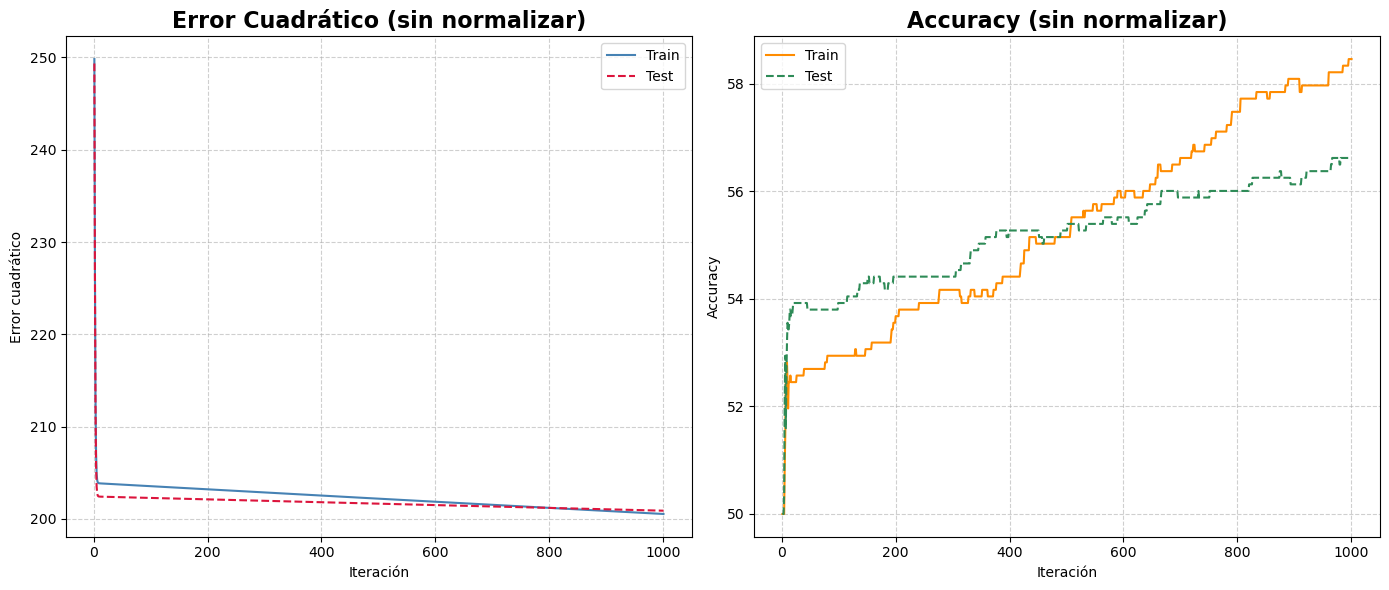

In [ ]:
# SIN NORMALIZAR 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

iter_train_no_norm = np.arange(1, len(loss_no_norm_train) + 1)

# --- Error cuadrático sin normalizar ---
axes[0].plot(iter_train_no_norm, loss_no_norm_train, label='Train', color='steelblue')
axes[0].plot(iter_train_no_norm, loss_no_norm_test, label='Test', color='crimson', linestyle='--')
axes[0].set_title('Error Cuadrático (sin normalizar)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Iteración')
axes[0].set_ylabel('Error cuadrático')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# --- Accuracy sin normalizar ---
axes[1].plot(iter_train_no_norm, acc_train_no_norm, label='Train', color='darkorange')
axes[1].plot(iter_train_no_norm, acc_test_no_norm, label='Test', color='seagreen', linestyle='--')
axes[1].set_title('Accuracy (sin normalizar)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Iteración')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Probemos ahora con datos normalizados:

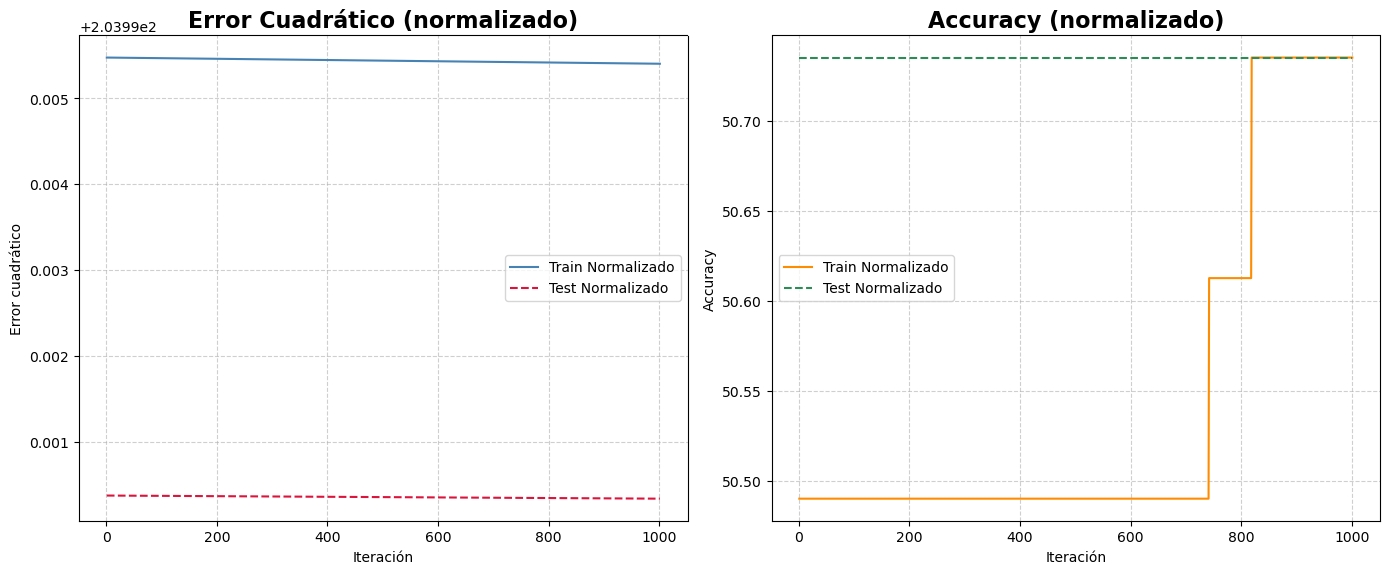

In [344]:
# CON NORMALIZAR

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

iter_train_norm = np.arange(1, len(loss_norm_train) + 1)
iter_test_norm = np.arange(1, len(loss_norm_test) + 1)

# --- Error cuadrático normalizado ---
axes[0].plot(iter_train_norm, loss_norm_train, label='Train Normalizado', color='steelblue')
axes[0].plot(iter_train_norm, loss_norm_test, label='Test Normalizado', color='crimson', linestyle='--')
axes[0].set_title('Error Cuadrático (normalizado)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Iteración')
axes[0].set_ylabel('Error cuadrático')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# --- Accuracy normalizado ---
axes[1].plot(iter_train_norm, acc_train_norm, label='Train Normalizado', color='darkorange')
axes[1].plot(iter_test_norm, acc_test_norm, label='Test Normalizado', color='seagreen', linestyle='--')
axes[1].set_title('Accuracy (normalizado)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Iteración')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

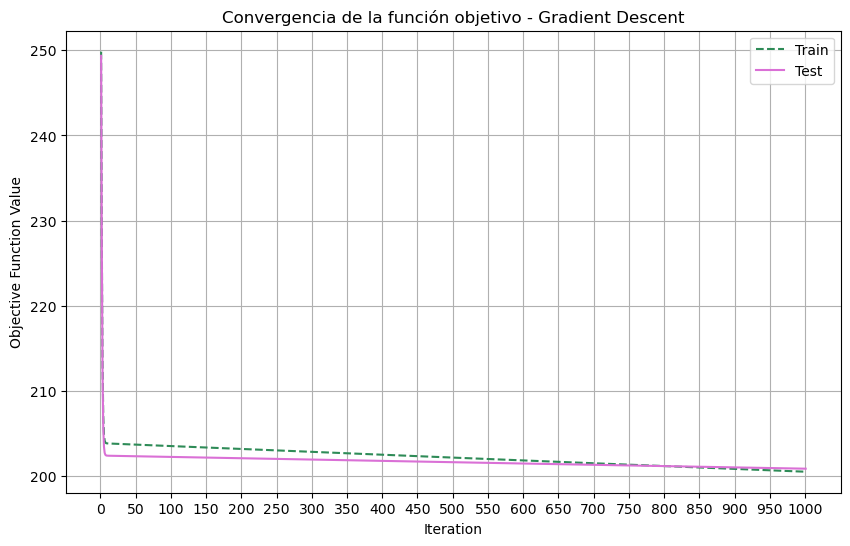

In [273]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, len(loss_no_norm_train) + 1), loss_no_norm_train, linestyle='--', color='seagreen', label='Train')

plt.plot(np.arange(1, len(loss_no_norm_test) + 1), loss_no_norm_test, linestyle='-', color='orchid', label='Test')

tick_interval = max(1, len(loss_no_norm_train) // 20)
plt.xticks(np.arange(0, len(loss_no_norm_train) + 1, step=tick_interval))

plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Convergencia de la función objetivo - Gradient Descent')
plt.grid(True)
plt.legend()  
plt.show()

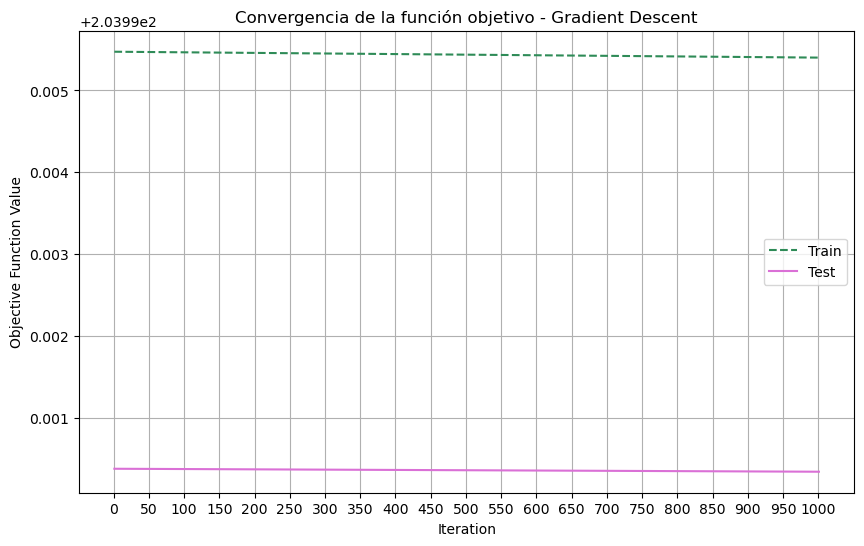

In [274]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, len(loss_norm_train) + 1), loss_norm_train, linestyle='--', color='seagreen', label='Train')

plt.plot(np.arange(1, len(loss_norm_test) + 1), loss_norm_test, linestyle='-', color='orchid', label='Test')

tick_interval = max(1, len(loss_norm_train) // 20)
plt.xticks(np.arange(0, len(loss_norm_train) + 1, step=tick_interval))

plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Convergencia de la función objetivo - Gradient Descent')
plt.grid(True)
plt.legend()  
plt.show()

Análisis del parámetro alfa

Ejecutando Gradient Descent con α = 5e-08 y normalizar = False
Ejecutando Gradient Descent con α = 1e-07 y normalizar = False
Ejecutando Gradient Descent con α = 3e-07 y normalizar = False
Ejecutando Gradient Descent con α = 2e-05 y normalizar = False
Criterio de convergencia alcanzado en iteración 13
Ejecutando Gradient Descent con α = 4e-06 y normalizar = False


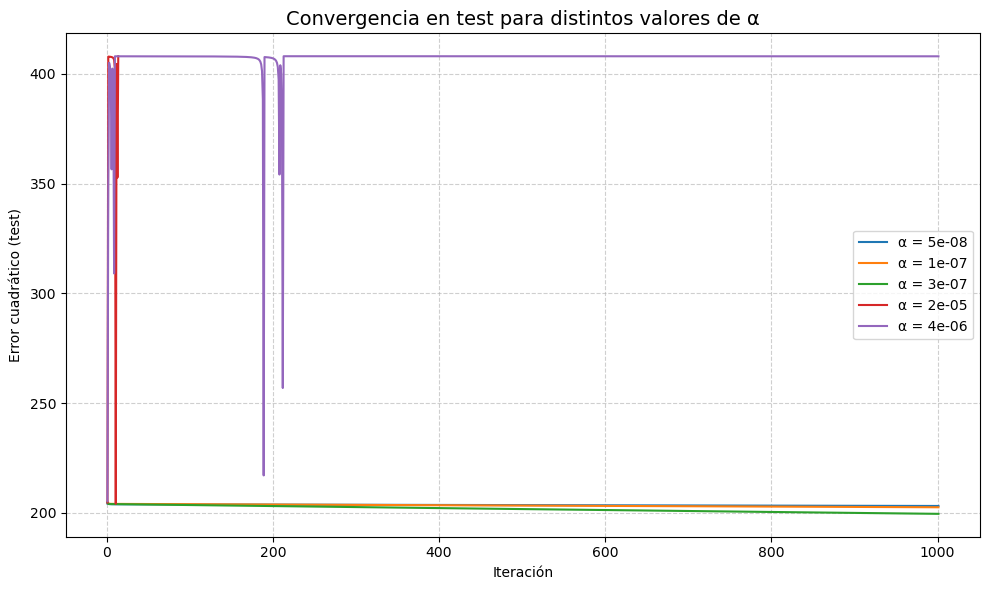

In [ ]:
alphas = [5e-8, 1e-7, 3e-7, 2e-5, 4e-6] # Valores de alpha a probar

loss_train_por_alpha = []  
loss_test_por_alpha = []  

for alpha in alphas:

    w = np.random.uniform(-1, 1, (i_train.shape[1], 1)) * 0.001
    b = np.random.uniform(-1, 1) * 0.001
    normalizar=False
    
    print(f"Ejecutando Gradient Descent con α = {alpha}")
   
    w_no_norm_train, b_no_norm_train, loss_no_norm_train, loss_no_norm_test, accuracy_no_norm_train, accuracy_no_norm_test = gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha, normalizar)
    loss_train_por_alpha.append(loss_no_norm_train)
    loss_test_por_alpha.append(loss_no_norm_test)

plt.figure(figsize=(10, 6))

for i, alpha in enumerate(alphas):
    iteraciones = np.arange(1, len(loss_test_por_alpha[i]) + 1)
    plt.plot(iteraciones, loss_test_por_alpha[i], label=f"α = {alpha}")

plt.title("Convergencia en test para distintos valores de α", fontsize=14)
plt.xlabel("Iteración")
plt.ylabel("Error cuadrático (test)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Análisis del tamaño de escalado de las imágenes

In [ ]:
sizes = [muy_chico, chico, mediano, original]
res_train = []
res_test = []
accuracies_train = []
accuracies_test = []
times = []

for size in sizes:
    print(f"\n--- Tamaño de imagen: {size} ---")

    src_dir = 'DatasetTP/Healthy'
    i_healthy = image_convert(src_dir, size) 
    d_healthy = np.ones((i_healthy.shape[0], 1)) * 0 

    src_dir = 'DatasetTP/Parkinson'  
    i_park = image_convert(src_dir, size) 
    d_park = np.ones((i_park.shape[0], 1)) 

    cant_healthy = i_healthy.shape[0] 
    cant_park = i_park.shape[0] 

    cant_healthy_train = round(cant_healthy * 0.5) 
    cant_healthy_test = cant_healthy - cant_healthy_train 

    cant_park_train = round(cant_park * 0.5) 
    cant_park_test = cant_park - cant_park_train 

    i_train = np.vstack((i_healthy[:cant_healthy_train], i_park[:cant_park_train])) 
    d_train = np.vstack((d_healthy[:cant_healthy_train], d_park[:cant_park_train])) 
    i_test = np.vstack((i_healthy[cant_healthy_train:], i_park[cant_park_train:])) 
    d_test = np.vstack((d_healthy[cant_healthy_train:], d_park[cant_park_train:])) 

    np.random.seed(42)  
    indices = np.random.permutation(i_train.shape[0])
    i_train = i_train[indices]
    d_train = d_train[indices]

    indices = np.random.permutation(i_test.shape[0])
    i_test = i_test[indices]
    d_test = d_test[indices]

    if (len(set(map(tuple, i_train)).intersection(map(tuple, i_test))) != 0):
        print("Error: La intersección entre los conjuntos de entrenamiento y test no es nula.")
        break

    # Inicialización
    w = np.random.uniform(-1, 1, (i_train.shape[1], 1)) * 0.001
    b = np.random.uniform(-1, 1) * 0.001
    normalizar=False
    alpha = 3e-7

    #gradiente
    start_time = time.time()

    w_opt_train, b_opt_train, valores_loss_train, valores_loss_test, accuracy_train, accuracy_test = gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha, normalizar)

    res_train.append(valores_loss_train)
    res_test.append(valores_loss_test)
    accuracies_train.append(accuracy_train)
    accuracies_test.append(accuracy_test)

    end_time = time.time()
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    times.append(end_time - start_time) 


    print(f"Tamaño de las imágenes: {size} = {size[0] * size[1]} pixeles")


--- Tamaño de imagen: (32, 32) ---
Tiempo de ejecución: 1.55 segundos
Tamaño de las imágenes: (32, 32) = 1024 pixeles

--- Tamaño de imagen: (64, 64) ---
Tiempo de ejecución: 8.28 segundos
Tamaño de las imágenes: (64, 64) = 4096 pixeles

--- Tamaño de imagen: (128, 128) ---
Tiempo de ejecución: 33.31 segundos
Tamaño de las imágenes: (128, 128) = 16384 pixeles

--- Tamaño de imagen: (256, 256) ---
Tiempo de ejecución: 141.14 segundos
Tamaño de las imágenes: (256, 256) = 65536 pixeles


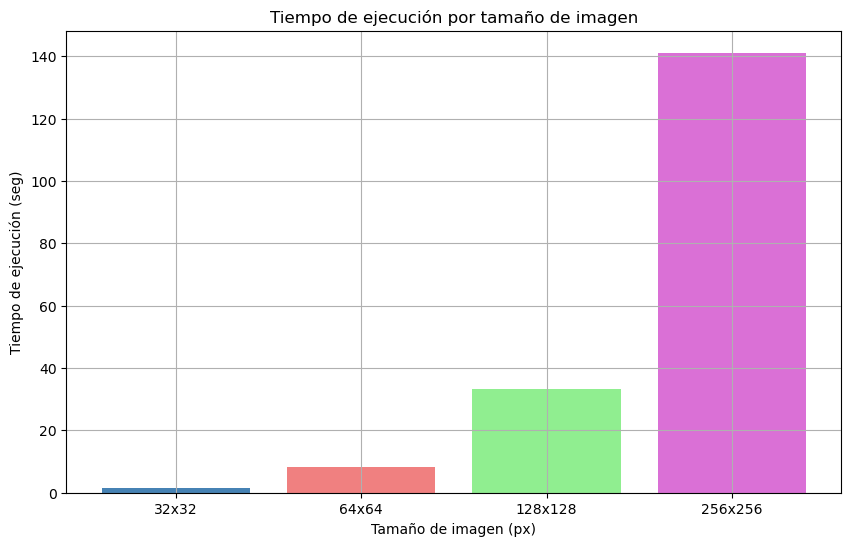

In [296]:
# Tiempo de ejecución según el tamaño de imagen
plt.figure(figsize=(10, 6))
plt.bar([f'{size[0]}x{size[1]}' for size in sizes], times, color=['steelblue', 'lightcoral', 'lightgreen', 'orchid'])


plt.xlabel('Tamaño de imagen (px)')
plt.ylabel('Tiempo de ejecución (seg)')
plt.title('Tiempo de ejecución por tamaño de imagen')
plt.grid(True)
plt.show()

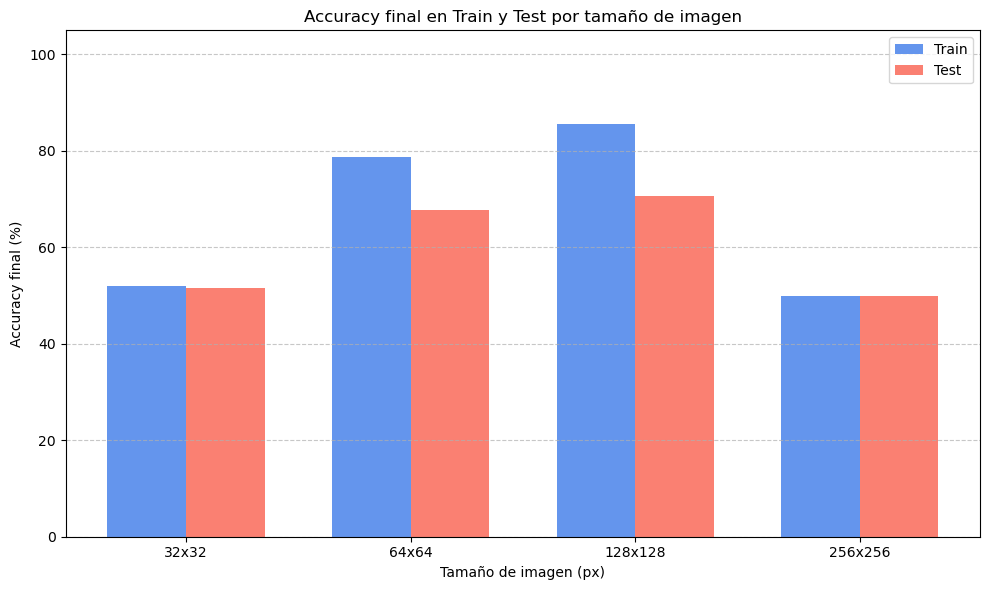

In [ ]:
# Accuracy según tamaño de imagen

# Extraemos la última accuracy de cada entrenamiento
acc_train = [accs[-1] for accs in accuracies_train]
acc_test = [accs[-1] for accs in accuracies_test]

labels = [f'{size[0]}x{size[1]}' for size in sizes]
x = np.arange(len(labels))
width = 0.35

# Gráfico
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, acc_train, width, label='Train', color='cornflowerblue')
plt.bar(x + width/2, acc_test, width, label='Test', color='salmon')

plt.xlabel('Tamaño de imagen (px)')
plt.ylabel('Accuracy final (%)')
plt.title('Accuracy final en Train y Test por tamaño de imagen')
plt.xticks(x, labels)
plt.ylim(0, 105)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
alpha = 3e-7# Mejor alfa encontrado
normalizar = False

w_optimo, b_optimo, loss_no_norm_train, loss_no_norm_test, accuracy_no_norm_train, accuracy_no_norm_test = gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha, normalizar)

# Cálculo de TP, TN, FP y FN 

z = i_train @ w_optimo + b_optimo
y_hat = (np.tanh(z) + 1) / 2
y_hat_labels = (y_hat >= 0.5).astype(int)
d_true = d_train.astype(int)

TP_desc_train = np.sum((y_hat_labels == 1) & (d_true == 1))
TN_desc_train = np.sum((y_hat_labels == 0) & (d_true == 0))
FP_desc_train = np.sum((y_hat_labels == 1) & (d_true == 0))
FN_desc_train = np.sum((y_hat_labels == 0) & (d_true == 1))

TP_pct = TP_desc_train / cant_park_train * 100 
TN_pct = TN_desc_train / cant_park_train * 100 
FP_pct = FP_desc_train / cant_park_train * 100 
FN_pct = FN_desc_train / cant_park_train * 100 

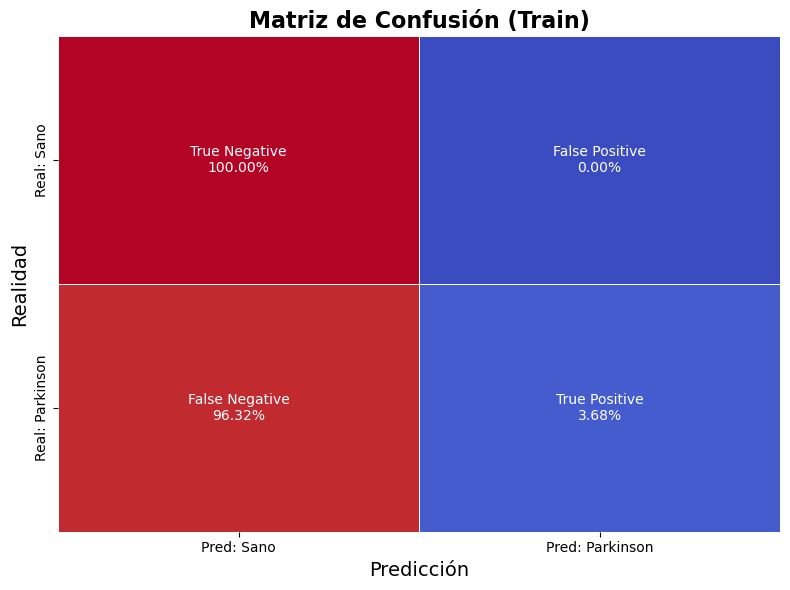

In [ ]:
conf_matrix_desc = np.array([[TN_pct, FP_pct],[FN_pct, TP_pct]])

labels_text = [["True Negative", "False Positive"],["False Negative", "True Positive"]]

annot = np.empty_like(conf_matrix_desc).astype(str)
for i in range(conf_matrix_desc.shape[0]):
    for j in range(conf_matrix_desc.shape[1]):
        annot[i, j] = f"{labels_text[i][j]}\n{conf_matrix_desc[i, j]:.2f}%"


plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix_desc, annot=annot, fmt='', cmap="coolwarm", 
            xticklabels=["Pred: Sano", "Pred: Parkinson"], 
            yticklabels=["Real: Sano", "Real: Parkinson"],
            cbar=False, linewidths=0.5, linecolor='white')

plt.title("Matriz de Confusión (Train)", fontsize=16, weight='bold')
plt.xlabel("Predicción", fontsize=14)
plt.ylabel("Realidad", fontsize=14)
plt.tight_layout()
plt.show()

## Parte 2: Ascenso de gradiente

In [368]:
def fwb_asc(i, w, b):
    z = i@w + b 
    print("z stats: min", np.min(z), "max", np.max(z))
    f = 1 / (1 + np.exp(-z))  
    print("f stats: min", np.min(f), "max", np.max(f))
    return f

In [369]:
def funcion_objetivo_asc(w, b, i, d):
    f = fwb_asc(i, w, b)
    epsilon = 1e-15
    f = np.clip(f, epsilon, 1 - epsilon)
    return -np.sum(d * np.log(f) + (1 - d) * np.log(1 - f))  

In [370]:
def df_w_asc(w, b, i, d):
    f = fwb_asc(i,w,b)         
    error = f - d                
    grad_w = i.T @ error         
    return grad_w

In [371]:
def df_b_asc(w, b, i, d):
    f = fwb_asc(i,w,b)   
    error = f - d       
    grad_b = np.sum(error)  
    return grad_b

In [372]:
def accuracy_asc(i, d, w, b):
    f = fwb_asc(i, w, b) 
    y_hat = (f >= 0.5).astype(int)  
    d = d.astype(int)  
    return np.mean(y_hat == d) * 100  

In [399]:
MAX_ITER = 1000

TOLERANCIA = 1e-7 

def grad_asc(w, b, i_train, i_test, d_train, d_test, alpha):

    i_train = i_train / 255.0
    i_test = i_test / 255.0

    iter = 0
    valores_logv_train = []
    valores_logv_test = []
    accuracy_train = []
    accuracy_test = []

    while iter <= MAX_ITER:

        valores_logv_train.append(funcion_objetivo_asc(w, b, i_train, d_train))
        valores_logv_test.append(funcion_objetivo_asc(w, b, i_test, d_test))

        acc_train = accuracy_asc(i_train, d_train, w, b)
        acc_test = accuracy_asc(i_test, d_test, w, b)
        accuracy_train.append(acc_train)
        accuracy_test.append(acc_test)

        gradiente_w = df_w_asc(w, b, i_train, d_train) 
        gradiente_b = df_b_asc(w, b, i_train, d_train)

        # Ascenso
        w_sig = w + alpha * gradiente_w
        b_sig = b + alpha * gradiente_b

        # Convergencia (comparando la pérdida real, no el negativo)
        criterio = np.abs(funcion_objetivo_asc(w_sig, b_sig, i_train, d_train) - funcion_objetivo_asc(w, b, i_train, d_train))

        if criterio < TOLERANCIA:
            print("Criterio de convergencia alcanzado en iteración", iter)
            break

        w = w_sig
        b = b_sig
        iter += 1
    print(f"Iter {iter} - LogVeros: {valores_logv_train[-1]:.4f} - Accuracy: {accuracy_train[-1]:.2f}")
    print("||grad_w||:", np.linalg.norm(gradiente_w))


    return w_sig, b_sig, valores_logv_train, valores_logv_test, accuracy_train, accuracy_test


In [398]:
w = np.random.uniform(-1, 1, (i_train.shape[1], 1)) * 0.1
b = np.random.uniform(-1, 1) * 0.1

In [400]:
alpha = 1e-3

w_optimo, b_optimo, valores_logv_train, valores_logv_test, accuracy_train_asc, accuracy_test_asc = grad_asc(w, b, i_train, i_test, d_train, d_test, alpha)

z stats: min -0.016429718232606392 max 0.0022270107656805135
f stats: min 0.4958926628344903 max 0.5005567524613155
z stats: min -0.013444402947752471 max 0.00223347028557949
f stats: min 0.4966389498892786 max 0.500558367339282
z stats: min -0.016429718232606392 max 0.0022270107656805135
f stats: min 0.4958926628344903 max 0.5005567524613155
z stats: min -0.013444402947752471 max 0.00223347028557949
f stats: min 0.4966389498892786 max 0.500558367339282
z stats: min -0.016429718232606392 max 0.0022270107656805135
f stats: min 0.4958926628344903 max 0.5005567524613155
z stats: min -0.016429718232606392 max 0.0022270107656805135
f stats: min 0.4958926628344903 max 0.5005567524613155
z stats: min -0.017231726515276293 max 0.0014233080446057478
f stats: min 0.49569217496505513 max 0.5003558269510817
z stats: min -0.016429718232606392 max 0.0022270107656805135
f stats: min 0.4958926628344903 max 0.5005567524613155
z stats: min -0.017231726515276293 max 0.0014233080446057478
f stats: min 0.4

In [ ]:
print("Train labels:", np.unique(d_train, return_counts=True))
print("Test labels:", np.unique(d_test, return_counts=True))

Train labels: (array([0., 1.]), array([408, 408]))
Test labels: (array([0., 1.]), array([408, 408]))


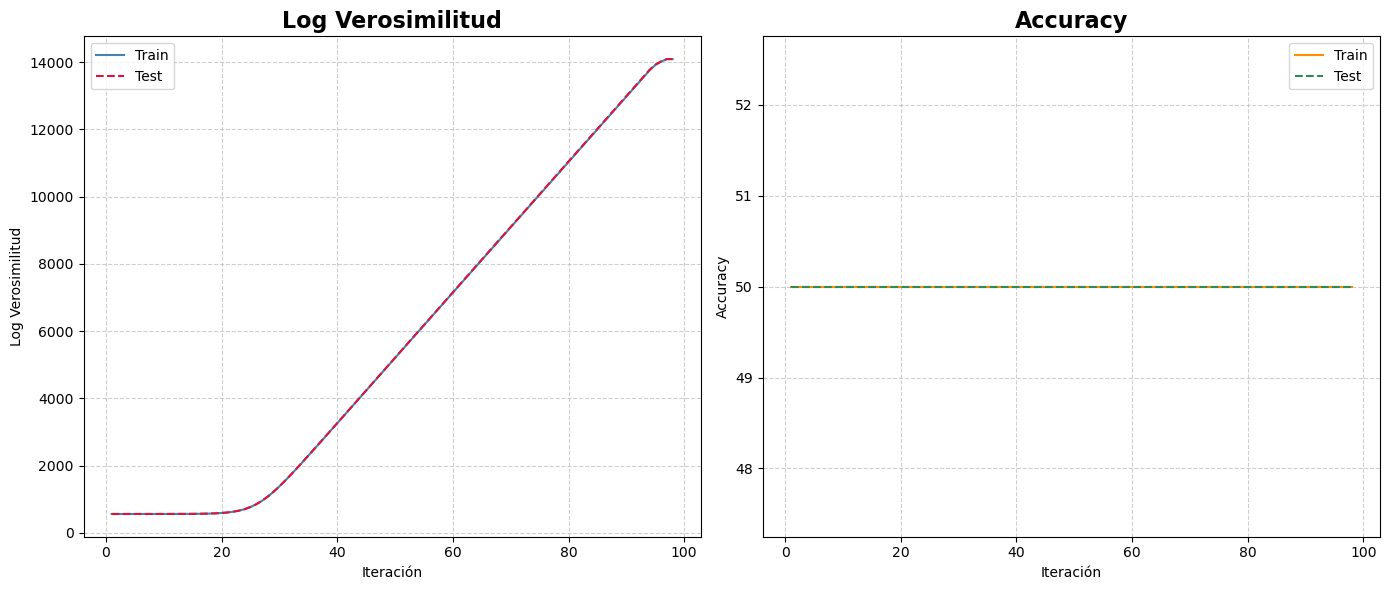

In [397]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

iter_train_asc = np.arange(1, len(valores_logv_train) + 1)
iter_test_asc = np.arange(1, len(valores_logv_test) + 1)

# --- Error cuadrático normalizado ---
axes[0].plot(iter_train_asc, valores_logv_train, label='Train', color='steelblue')
axes[0].plot(iter_train_asc, valores_logv_test, label='Test', color='crimson', linestyle='--')
axes[0].set_title('Log Verosimilitud', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Iteración')
axes[0].set_ylabel('Log Verosimilitud')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# --- Accuracy normalizado ---
axes[1].plot(iter_train_asc, accuracy_train_asc, label='Train', color='darkorange')
axes[1].plot(iter_test_asc, accuracy_test_asc, label='Test', color='seagreen', linestyle='--')
axes[1].set_title('Accuracy', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Iteración')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
